# Simple EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("/kaggle/input/nfs-project-2-data/stock_data.csv")
df.columns = df.columns.str.lower()
df.head()

,text,sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [3]:
df.isna().sum()

text         0
sentiment    0
dtype: int64

In [4]:
# Create a mapping of labels to numbers
rawid2label = {
    -1: 'negative',
    1: 'positive'
}
labels = ['negative', 'positive']
id2label = {k:v for k,v in enumerate(labels)}
label2id = {v:k for k,v in enumerate(labels)}
print(rawid2label)
print(labels)
print(id2label)
print(label2id)

{-1: 'negative', 1: 'positive'}
['negative', 'positive']
{0: 'negative', 1: 'positive'}
{'negative': 0, 'positive': 1}


In [5]:
df['sentiment'] = df['sentiment'].map(rawid2label)
df['label'] = df['sentiment'].map(label2id)

df.head()

,text,sentiment,label
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,positive,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,positive,1
2,user I'd be afraid to short AMZN - they are lo...,positive,1
3,MNTA Over 12.00,positive,1
4,OI Over 21.37,positive,1


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


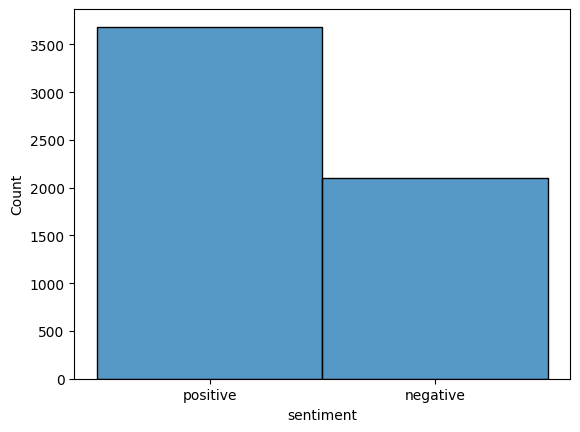

In [6]:
# Distribution of sentiment
sns.histplot(df["sentiment"])
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


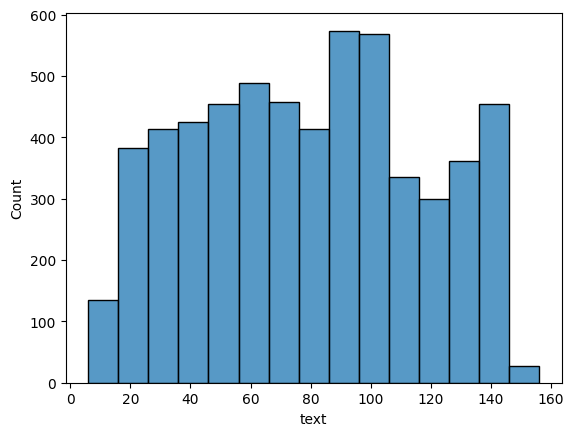

In [7]:
# Distribution of text length
sns.histplot(df["text"].str.len(), binwidth=10)
plt.show()

In [8]:
# Sample of texts from each sentiment
sample_size = 3
df.groupby('sentiment').apply(lambda x: x.sample(sample_size))

text sentiment  \
sentiment                                                                     
negative  2799  CAT Gap fill area approaching. Will be filled ...  negative   
          2676  BAC Out of my short for  Should go around 12.0...  negative   
          4994  Debate over when to reopen the economy has lef...  negative   
positive  2075  DOV  Nov eport  Feb early release earnings nex...  positive   
          2469  NFX daily had the buy, its in extreme overboug...  positive   
          5139  The latest stock rally reflects optimism about...  positive   

                label  
sentiment              
negative  2799      0  
          2676      0  
          4994      0  
positive  2075      1  
          2469      1  
          5139      1

# Sentiment Analysis 
- Using Hugging Face Transformers

In [9]:
# Try out different models here

model_name = "roberta-large"

## Load dataset

In [10]:
# Split train_df into 80% training + 10% validation + 10% testing

train = df.sample(frac=0.8, random_state=42)
temp = df.drop(train.index)

valid = temp.sample(frac=0.5, random_state=42)
test = temp.drop(valid.index)

In [11]:
# Data size
print(f"Training set: {len(train)} rows")
print(f"Training set: {len(valid)} rows")
print(f"Test set: {len(test)} rows")

Training set: 4633 rows
Training set: 579 rows
Test set: 579 rows


In [12]:
train

,text,sentiment,label
1891,MCP take-over chatter... (I know don't laugh...),negative,0
1550,"AMZN 1,200 lot bid in the Feb weekly 255P. 27 ...",negative,0
1049,KO made with sugar is sold at local COST. Cons...,positive,1
2523,HNZ Another American Institution sold to forei...,negative,0
156,Will watch the close carefully then decide whe...,negative,0
...,...,...,...
5235,The stricken Bank of Jinzhou will unload $21 b...,positive,1
1279,AAP close- would like to see Williams back und...,positive,1
5672,"Sensex opens 2,307 points lower at 27,609, Nif...",negative,0
1555,CSN 413K worth sold in block trades so far tod...,positive,1


In [13]:
from datasets import Dataset

train_ds = Dataset.from_pandas(train)
valid_ds = Dataset.from_pandas(valid)
test_ds = Dataset.from_pandas(test)

train_ds, valid_ds, test_ds

(Dataset({
     features: ['text', 'sentiment', 'label', '__index_level_0__'],
     num_rows: 4633
 }),
 Dataset({
     features: ['text', 'sentiment', 'label', '__index_level_0__'],
     num_rows: 579
 }),
 Dataset({
     features: ['text', 'sentiment', 'label', '__index_level_0__'],
     num_rows: 579
 }))

In [14]:
train_ds[5]

{'text': "CTGX this is what what I mean by a 'high, tight' consolidation following high-volume run, v bullish  ",
 'sentiment': 'positive',
 'label': 1,
 '__index_level_0__': 3937}

## Preprocess

In [15]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

RobertaTokenizerFast(name_or_path='roberta-large', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [16]:
# Test out the tokenizer

tokenizer(train_ds['text'][0])

{'input_ids': [0, 448, 7496, 185, 12, 2137, 29205, 734, 36, 100, 216, 218, 75, 7923, 41137, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [17]:
# Evaluate using accuracy
from datasets import load_metric

accuracy = load_metric('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [18]:
# Max text length is only about 160, so no need truncation
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=False)

train_ds = train_ds.map(preprocess_function, batched=True)
valid_ds = valid_ds.map(preprocess_function, batched=True)
test_ds = test_ds.map(preprocess_function, batched=True)

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [19]:
train_ds[5]

{'text': "CTGX this is what what I mean by a 'high, tight' consolidation following high-volume run, v bullish  ",
 'sentiment': 'positive',
 'label': 1,
 '__index_level_0__': 3937,
 'input_ids': [0,
  7164,
  534,
  1000,
  42,
  16,
  99,
  99,
  38,
  1266,
  30,
  10,
  128,
  3530,
  6,
  3229,
  108,
  13581,
  511,
  239,
  12,
  33313,
  422,
  6,
  748,
  12115,
  1437,
  1437,
  2],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [20]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Train

In [21]:
# To avoid some warnings on Kaggle notebook
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [22]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(labels), id2label=id2label, label2id=label2id, 
    ignore_mismatched_sizes=True)

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# Adapted from https://huggingface.co/docs/transformers/tasks/sequence_classification
training_args = TrainingArguments(
    output_dir="stock-sentiment-detector",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True, # to load the version with best validation loss at the end
    save_total_limit=1,
    report_to="none"
)

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.427052,0.823834
2,No log,0.402116,0.846287
3,No log,0.482889,0.848014
4,0.356300,0.707532,0.851468
5,0.356300,0.857562,0.844560
6,0.356300,0.822813,0.853195
7,0.100000,1.006772,0.856649
8,0.100000,1.186312,0.849741
9,0.100000,1.158317,0.853195
10,0.100000,1.186972,0.853195


TrainOutput(global_step=1450, training_loss=0.1656485866678172, metrics={'train_runtime': 873.7379, 'train_samples_per_second': 53.025, 'train_steps_per_second': 1.66, 'total_flos': 4016926325565384.0, 'train_loss': 0.1656485866678172, 'epoch': 10.0})

## Evaluate on test set

In [25]:
# Accuracy on test set
predictions = trainer.predict(test_ds)
preds = np.argmax(predictions.predictions, axis=-1)
accuracy.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.846286701208981}

# Sample inference

In [26]:
texts = [
    "Won't believe AAP uptrend is back until it crosses above MA(50)",
    "AAP VOME today is impressive. At this rate and well probably get to 30M shares traded today."
]

In [27]:
inputs = tokenizer(texts, return_tensors="pt", padding=True)
model = model.to('cpu') # put model to cpu
logits = model(**inputs).logits
print([model.config.id2label[item.item()] for item in logits.argmax(axis=-1)])

['negative', 'positive']
